<a href="https://colab.research.google.com/github/ca-scribner/quick_draw/blob/master/GAN_QD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary

The following applies the Generative Adversarial Network (GAN) technique to train two models, a generator and a discriminator.  The goal of the generator is to produce realistic looking images (in this case, sketches of baseballs), whereas the goal of the discriminator is to determine whether it has been passed a real image (from the true data set) or a fake image (from the generator).  To do this, a subset of baseball sketches  from the Quick, Draw! dataset has been used here.  

Some very high level discussion of results is included, but this was generally intended as a proof-of-concept test and reminder to myself for when I needed to apply something similar in a production setting

The present notebook was inspired by [this](https://colab.research.google.com/drive/1MKS7r_D8Pci5H1aKWId6oqDTP5BLLKoB#scrollTo=uV0yiKpzNP1b) helpful writeup.

Skipping to the fun part - here is a gif of what the generator generated throughout training.  We can see it learns a semi-recognizable version of a baseball early on, but doesn't seem to refine much past that.  Settings tweaks or other techniques can likely make it converge a bit better, but this was just meant to be a proof of concept.

![GAN Generator Training](https://media.giphy.com/media/jqeqq4TiaYPEC4iZus/giphy.gif)

# Install and load necessary packages

In [1]:
!pip install tensorflow-gpu==2.0.0-beta1

In [2]:
import tensorflow as tf
tf.executing_eagerly()

import glob
import imageio
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time
import re
import cv2

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.externals import joblib

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Initialize Settings

In [0]:
random_seed = 1
n_samples = 3000
names = ['baseball']

n_jobs = -1

# 28x28 pixels, 1 channel
IMAGE_SHAPE = (28, 28, 1)

BUFFER_SIZE = 1000
BATCH_SIZE = 64
DIM_NOISE = 100

EPOCHS = 50

# Dropout for generator on first layer (input parameters)
GENERATOR_DROPOUT = 0.0

# Optimizer learning rate
# Note: Previous attempts with learning rate == 0.001 lead to mode collapse in the generator
LEARNING_RATE = 0.0001

# Download, load, and preprocess data

Access data like described [here](https://github.com/googlecreativelab/quickdraw-dataset#preprocessed-dataset)

In [4]:
!gsutil -m cp gs://quickdraw_dataset/full/numpy_bitmap/baseball.npy .
# !gsutil -m cp gs://quickdraw_dataset/full/numpy_bitmap/basketball.npy .

Copying gs://quickdraw_dataset/full/numpy_bitmap/baseball.npy...
- [1/1 files][101.2 MiB/101.2 MiB] 100% Done                                    
Operation completed over 1 objects/101.2 MiB.                                    


In [0]:
def get_data(names=None, nSamples=1000, randomSeed=1, datapath="./data/",
                datasetPrefix="full_numpy_bitmap_", datasetExtension=".npy" ,
                data_shape=None):
    """
    Returns a pandas DataFrame with the requested Quick, Draw! data.

    :param names: Names of drawings to be pulled from data
    :param nSamples: Number of samples to be loaded per named drawing
    :param randomSeed: If not False, Random seed passed to np.random.seed
    :param datapath: Path to Quick Draw drawing data (in .npy format)
    :param datasetPrefix, datasetExtension: Prefix and extension on filenames.  Filenames to be constructed as:
                                            datasetPrefix + name + datasetExtension

    :return: Tuple of: 
        data: Numpy array of loaded data
        labels: Numpy array of label integers
        nameDict: Dictionary mapping label name (key) to label integer (value)
    """
    datafiles = [datasetPrefix + name + datasetExtension for name in names]
    nameDict = {}
    
    if randomSeed:
        np.random.seed(randomSeed)

    classNumber = 0
    for name, fname in zip(names, datafiles):
        nameDict[name] = classNumber
        fullpath = os.path.join(datapath, fname)
        print(f"Loading {nSamples} samples for {name} from {fullpath}")
        temp = np.load(fullpath).astype('float32')
        temp = temp[np.random.choice(temp.shape[0], nSamples, replace=False)]

        try:
            data = np.concatenate((data, temp))
            labels = np.concatenate((labels, np.ones(temp.shape[0], dtype='int') * classNumber))
        except NameError:
            data = temp
            labels = np.ones(temp.shape[0], dtype='int32') * classNumber
        
        classNumber += 1
    return data, labels, nameDict

def prepare_data(data, image_shape=None, ):
    if image_shape is None:
        image_shape = IMAGE_SHAPE
        
    # Scale and shift about 0
    data = data.copy() / (255.0 / 2) - 1
    
    # Reshape to image shape (adds color channel)
    data = data.reshape(-1, *image_shape)
    
    return data
  
def prepare_dataset(data, labels=None, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE):
  if labels:
    dataset = tf.data.Dataset.from_tensor_slices((data, labels))
  else:
    dataset = tf.data.Dataset.from_tensor_slices((data))

  # Randomize, but don't buffer all the data
  dataset = dataset.shuffle(buffer_size)

  # Serve data up in batches
  dataset = dataset.batch(batch_size)

  return dataset

In [6]:
data, labels, label2int = get_data(names=names, nSamples=n_samples, 
                                   randomSeed=random_seed, datasetPrefix='',
                                   datapath='./')
data = prepare_data(data)

# Use python 3.7's feature that dictionary keys are in insertion order
# to make a reverse map
int2label = [k for k in label2int.keys()]

Loading 3000 samples for baseball from ./baseball.npy


In [0]:
X_train = data.copy()
y_train = labels.copy()

In [0]:
dataset_train = prepare_dataset(X_train, labels=None)

# Visualize the data

Take a look at some random images

In [0]:
def draw_sketch(x, y=None, cmap='gray_r', ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # Only plot the first output channel...
    if len(x.shape) < 3:
        x = x.reshape(x.shape[0], x.shape[1], 1)
    ax.imshow(x[:, :, 0], cmap=cmap)
    
    if y is not None:
        ax.text(x.shape[0] * 0.1, x.shape[1] * 0.1, str(y), color='r')
    
    return ax

def draw_sketches(x, y=None, subplot_shape=None, fig=None, savefig=None, **kwargs):
    if subplot_shape is None:
        # Get subplotShape by the next round square
        temp = math.ceil(math.sqrt(x.shape[0]))
        subplot_shape = (temp, temp)
        
    if fig is None:
        fig, axs = plt.subplots(nrows=subplot_shape[0], ncols=subplot_shape[1], figsize=(subplot_shape[1]*2, subplot_shape[0]*2))
        
    for i in range(subplot_shape[0]):
        for j in range(subplot_shape[1]):
            k = i * subplot_shape[1] + j
            
            try:
                thisy = y[k]
            except TypeError:
                thisy = None
            
            draw_sketch(x[k], thisy, ax=axs[i, j], **kwargs)
            
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
            
    if savefig:
        fig.savefig(savefig)
    
    return fig

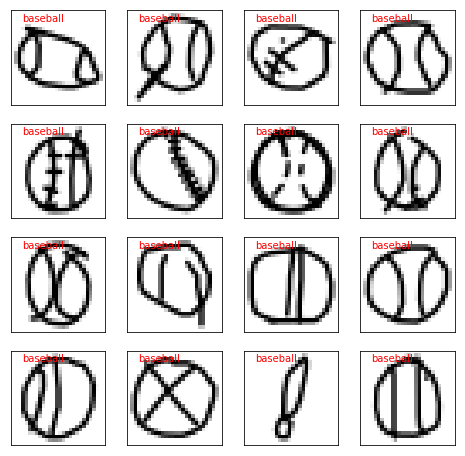

In [10]:
# Some random drawings
random_indices = np.random.choice(np.arange(data.shape[0]), size=16, replace=False)
these_labels = [int2label[labels[i]] for i in random_indices]
draw_sketches(x=data[random_indices], y=these_labels)
plt.show()

# Build the models and training loop

In [0]:
def build_generator(dropout=0.4):
    """
    Build and return a generator
    
    Note that use_bias==False throughout because we do BatchNormalization, which introduces its own bias term.
    Normalization is used throughout as it has been shown to reduce training time.  It is akin to why we normalize
    inputs before passing them to the model at all.
    """
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Dense(7*7*256, input_shape=(DIM_NOISE,), use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    # Shape = (7*7*256,)
    model.add(tf.keras.layers.Dropout(dropout))
    
    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    # Shape = (7, 7, 256)
    model.add(tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(5, 5),
                                              strides=(1, 1),
                                              padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    # Shape = (7, 7, 128)
    
    model.add(tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(5, 5), 
                                              strides=(2, 2),
                                              padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    # Shape = (14, 14, 64)

    model.add(tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=(5, 5), 
                                              strides=(2, 2),
                                              padding='same', use_bias=False,
                                              activation='tanh'))
    # Mistake from before - was using LeakyReLU when should be using tanh apparently
    # Not sure exactly why tanh is better here.  
#     model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.LeakyReLU())
    # Shape = (28, 28, 1)
    return model

In [12]:
generator = build_generator(GENERATOR_DROPOUT)
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
dropout (Dropout)            (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         5

Example of generator in action:

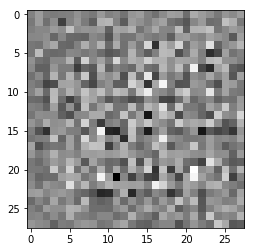

In [13]:
noise = tf.random.normal((1, DIM_NOISE))
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

And the discriminator (with parameters taken based on earlier use with this dataset and model structure)

In [0]:
# (taken from grid search on initial model training)
params = {
    'filters_1': 16,
    'kernel_size_1': (5, 5),
    'dropout_1': 0.25,
    'filters_2': 16,
    'kernel_size_2': (5, 5),
    'dropout_2': 0.5,
    'dense_layer_sizes': [16],
    'n_labels': 1,
    'output_activation': False,
}

def build_model(filters_1=16, kernel_size_1=None, dropout_1=0.25,
                filters_2=16, kernel_size_2=None, dropout_2=0.50,
                dense_layer_sizes=None, n_labels=1, output_activation=True):
  """
  Retruns an uncompiled tf.keras.Model
  
  Model includes:
    BatchNormalization between convolutional layers (cited to reduce training time
    by similar concept to normalizing inputs for NN's
    Dropout between convolutional layers to reduce overfitting
    LeakyReLU activation for inner layers to avoid vanishing gradients and dead neurons
    Optional activation on the output layer
      None if we want to use this as input for a loss function that prefers inputs as logits
      Sigmoid if we have a binary classification problem
      Softmax if we have a multi-class classification problem
  """
  
  if dense_layer_sizes == None:
    dense_layer_sizes = []

  if kernel_size_1 == None:
    kernel_size_1 = (5, 5)

  if kernel_size_2 == None:
    kernel_size_2 = (5, 5)

  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Conv2D(filters=filters_1, kernel_size=kernel_size_1,
                                   strides=(1, 1), padding='same',
                                   input_shape=IMAGE_SHAPE))
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(dropout_1))
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Conv2D(filters=filters_2, kernel_size=kernel_size_2, 
                                   strides=(1, 1), padding='same') )
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(dropout_2))
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Flatten())

  for size in dense_layer_sizes:
    model.add(tf.keras.layers.Dense(size))
    model.add(tf.keras.layers.LeakyReLU())


  if n_labels == 2:
    print(f'Detected binary classification - overwriting n_labels to set to 1 (was {n_labels})')
    n_labels = 1

  if output_activation is True:
    if n_labels == 1:
    # Binary classification so use sigmoid if applying activation
      output_activation = 'sigmoid'
    else:
      # Multiclass classification so use softmax
      output_activation = 'softmax'
  elif not output_activation:
    output_activation = None
  model.add(tf.keras.layers.Dense(n_labels, activation=output_activation))

  return model
  
build_discriminator_model = lambda : build_model(**params)

In [15]:
discriminator = build_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 16)        64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 16)        0         
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        6416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)         

In [16]:
discriminator(generated_image, training=False)

<tf.Tensor: id=1072, shape=(1, 1), dtype=float32, numpy=array([[-0.00208352]], dtype=float32)>

Define the loss functions

In [0]:
# from_logits==True because we have not applied an activation to the last layer
# of our discriminator...I think.  if from_logits==True, the function applies
# sigmoid.  I think we prefer it this way rather than a sigmoid activation 
# from_logits==False because this is more computationally efficient?  If 
# from_logits==False, the inputs are interpreted as probabilities (eg from 0 to 1)
# 
# cross_entropy is a function that accepts (y_true, y_pred), where y's are classes 0/1 
# (or for y_pred, likely a value between 0 and 1)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    """
    Discriminator loss function compares real output 1's and fake output to 0's
    
    real_output and fake_output will be a Tensor of shape [n_records] with values between 0 and (1?  but we don't scale it)
    """
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    """
    Generator loss function compares fake output to 1's
    
    The generator is doing well if a fake image gets assigned a value near 1 by the discriminator
    """   
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Define the optimizers and checkpointing

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
discriminator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

checkpoint_dir = './training_checkpoints_GAN_1cat_highdef'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

Define the training loop

In [0]:
# Visualization settings
num_examples_to_generate = 16
# Seed used repeatedly over time to make visualization gifs
seed = tf.random.normal([num_examples_to_generate, DIM_NOISE])

In [0]:
# This function is passed a batch of images for a single training step, and must generate noise images 
# and train both models
@tf.function
def train_step(images):
    
    # Generate the random noise to seed images
    noise = tf.random.normal((BATCH_SIZE, DIM_NOISE))
    
    # GradientTape is a context manager that monitors any "watched" variables (trainable variables, like the params
    # in layers/models are automatically watched, but you can also do gen_tape.watch(some_tf_variable))
    # After we leave this context (leave the with block), the GradientTape exists until we extract the gradients
    # using GradientTape.gradient(). If we want more than one gradient, we need to set persistent==True or use
    # multiple GradientTapes
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Make the fake images
        generated_images = generator(noise, training=True)
        
        # Classify the real and fake images
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        # Compute losses
        disc_loss = discriminator_loss(real_output, fake_output)
        gen_loss = generator_loss(fake_output)
    
    # Compute the gradients for both models using our GradientTapes
    # Could we also do persistent==True, call the same tape twice, then do del tape to clean up?
    #                                          (tensor to be differentiated, variables to track)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # Pass gradients to optimizer
    # This step applies (a single step?) of optimization based on the gradients we pass
    # In normal optimization the optimizer.minimize() computes the gradients and then steps in that direction, but
    # if we want to generate our own gradients we do this instead.  See:
    # https://www.tensorflow.org/api_docs/python/tf/train/Optimizer
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [0]:
def train(dataset, epochs, epoch_offset=0):
  for epoch in range(epochs):
    verbose_epoch = (epoch % 100) == 0
    
    epoch = epoch + epoch_offset # Let me restart training without overwriting old files
    start = time.time()

    # Run through all data in dataset
    for i, image_batch in enumerate(dataset):
      # Add some rough printing of progress
      if verbose_epoch:
        if i % 10 == 0:
          try:
            print(f' -> batch {i-1} done in {time.time() - start_batch}')
          except NameError:
            pass
          start_batch = time.time()
          print(f'batch {i}', end='')
      train_step(image_batch)

    # Produce images for the progress GIF along the way
    generate_and_save_images(generator, epoch + 1, seed, show=verbose_epoch)

    # Save the model periodically
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

    if verbose_epoch:
      print(f"Time for epoch {epoch+1} was {time.time() - start}")
      print()

Define routines to capture a visual of the training progress

In [0]:
def generate_and_save_images(model, epoch, test_input, show=False):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).  <--does this matter for anywhere else?  Dropout?
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_high_def{:04d}.png'.format(epoch))
  if show:
    plt.show()
  plt.close()


# Train the model

batch 0

W0711 22:11:28.174987 139673844426624 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:182: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


 -> batch 9 done in 4.036292791366577
batch 10 -> batch 19 done in 0.10368847846984863
batch 20 -> batch 29 done in 0.10384798049926758
batch 30 -> batch 39 done in 0.10123562812805176
batch 40

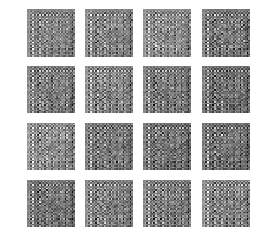

Time for epoch 1 was 6.779642343521118

 -> batch -1 done in 82.18014335632324
batch 0 -> batch 9 done in 0.09033083915710449
batch 10 -> batch 19 done in 0.10344791412353516
batch 20 -> batch 29 done in 0.10123133659362793
batch 30 -> batch 39 done in 0.1010901927947998
batch 40

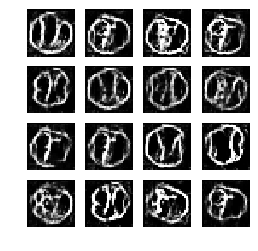

Time for epoch 101 was 1.1064205169677734

 -> batch -1 done in 81.92067861557007
batch 0 -> batch 9 done in 0.08902621269226074
batch 10 -> batch 19 done in 0.10279130935668945
batch 20 -> batch 29 done in 0.10044360160827637
batch 30 -> batch 39 done in 0.10106921195983887
batch 40

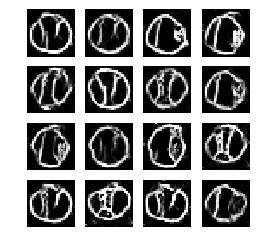

Time for epoch 201 was 1.1165192127227783

 -> batch -1 done in 82.01481318473816
batch 0 -> batch 9 done in 0.09129047393798828
batch 10 -> batch 19 done in 0.10285019874572754
batch 20 -> batch 29 done in 0.10111165046691895
batch 30 -> batch 39 done in 0.10149765014648438
batch 40

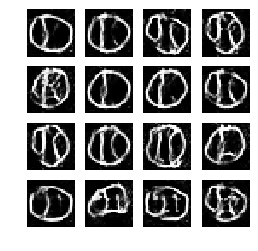

Time for epoch 301 was 1.1281497478485107

 -> batch -1 done in 82.75534129142761
batch 0 -> batch 9 done in 0.09006476402282715
batch 10 -> batch 19 done in 0.10261917114257812
batch 20 -> batch 29 done in 0.10113787651062012
batch 30 -> batch 39 done in 0.10259795188903809
batch 40

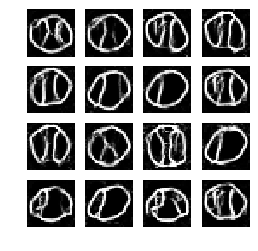

Time for epoch 401 was 1.1097304821014404

 -> batch -1 done in 82.46072316169739
batch 0 -> batch 9 done in 0.08893895149230957
batch 10 -> batch 19 done in 0.10331010818481445
batch 20 -> batch 29 done in 0.10234355926513672
batch 30 -> batch 39 done in 0.10209345817565918
batch 40

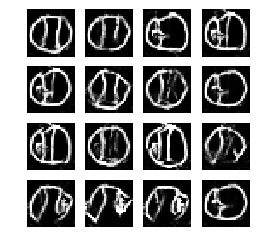

Time for epoch 501 was 1.1111371517181396

 -> batch -1 done in 82.77520513534546
batch 0 -> batch 9 done in 0.08983826637268066
batch 10 -> batch 19 done in 0.10079312324523926
batch 20 -> batch 29 done in 0.10126495361328125
batch 30 -> batch 39 done in 0.10119915008544922
batch 40

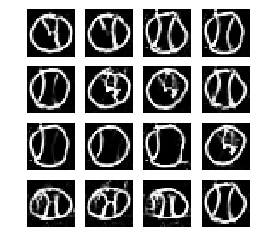

Time for epoch 601 was 1.1169886589050293

 -> batch -1 done in 82.31184339523315
batch 0 -> batch 9 done in 0.08914041519165039
batch 10 -> batch 19 done in 0.1024315357208252
batch 20 -> batch 29 done in 0.10600662231445312
batch 30 -> batch 39 done in 0.09784698486328125
batch 40

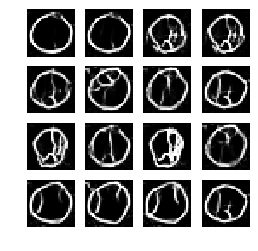

Time for epoch 701 was 1.110973596572876

 -> batch -1 done in 82.5318865776062
batch 0 -> batch 9 done in 0.08949804306030273
batch 10 -> batch 19 done in 0.10201048851013184
batch 20 -> batch 29 done in 0.10077524185180664
batch 30 -> batch 39 done in 0.10820484161376953
batch 40

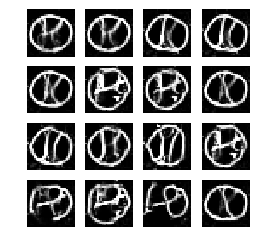

Time for epoch 801 was 1.115036964416504

 -> batch -1 done in 82.08699297904968
batch 0 -> batch 9 done in 0.08851432800292969
batch 10 -> batch 19 done in 0.10225939750671387
batch 20 -> batch 29 done in 0.10840988159179688
batch 30 -> batch 39 done in 0.10146570205688477
batch 40

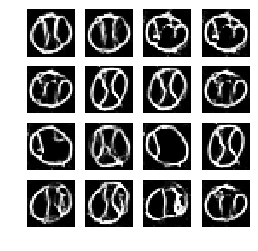

Time for epoch 901 was 1.1125705242156982

 -> batch -1 done in 82.35208559036255
batch 0 -> batch 9 done in 0.09175753593444824
batch 10 -> batch 19 done in 0.10238766670227051
batch 20 -> batch 29 done in 0.10193443298339844
batch 30 -> batch 39 done in 0.10072946548461914
batch 40

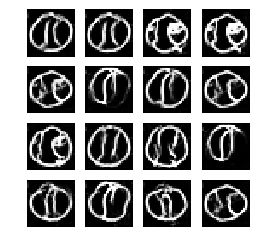

Time for epoch 1001 was 2.31246018409729

 -> batch -1 done in 84.40952610969543
batch 0 -> batch 9 done in 0.08986425399780273
batch 10 -> batch 19 done in 0.10775399208068848
batch 20 -> batch 29 done in 0.10408568382263184
batch 30 -> batch 39 done in 0.0971379280090332
batch 40

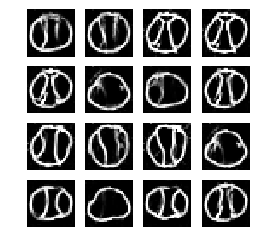

Time for epoch 1101 was 1.1194813251495361

 -> batch -1 done in 82.9550507068634
batch 0 -> batch 9 done in 0.08884811401367188
batch 10 -> batch 19 done in 0.10272526741027832
batch 20 -> batch 29 done in 0.10121917724609375
batch 30 -> batch 39 done in 0.10082840919494629
batch 40

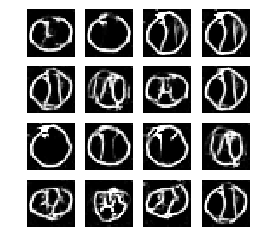

Time for epoch 1201 was 1.1271240711212158

 -> batch -1 done in 82.76036024093628
batch 0 -> batch 9 done in 0.0888071060180664
batch 10 -> batch 19 done in 0.10060834884643555
batch 20 -> batch 29 done in 0.10149979591369629
batch 30 -> batch 39 done in 0.10074257850646973
batch 40

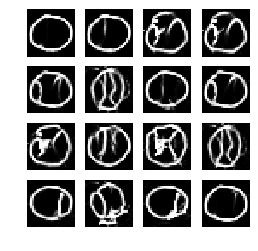

Time for epoch 1301 was 1.1114366054534912

 -> batch -1 done in 82.70408701896667
batch 0 -> batch 9 done in 0.08945465087890625
batch 10 -> batch 19 done in 0.10243082046508789
batch 20 -> batch 29 done in 0.1105656623840332
batch 30 -> batch 39 done in 0.10156536102294922
batch 40

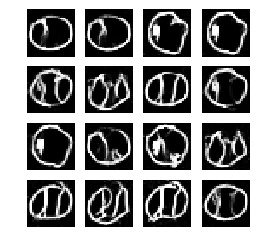

Time for epoch 1401 was 1.1520795822143555

CPU times: user 17min 10s, sys: 1min 10s, total: 18min 20s
Wall time: 20min 49s


In [23]:
%%time
train(dataset_train, 1500)

batch 0 -> batch 9 done in 0.1434011459350586
batch 10 -> batch 19 done in 0.1346602439880371
batch 20 -> batch 29 done in 0.1141359806060791
batch 30 -> batch 39 done in 0.10201168060302734
batch 40

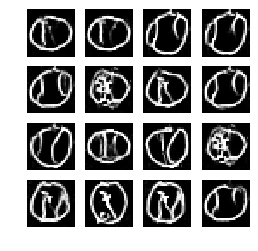

Time for epoch 1502 was 1.3447494506835938

 -> batch -1 done in 83.2261438369751
batch 0 -> batch 9 done in 0.09018206596374512
batch 10 -> batch 19 done in 0.10243010520935059
batch 20 -> batch 29 done in 0.10142850875854492
batch 30 -> batch 39 done in 0.10116243362426758
batch 40

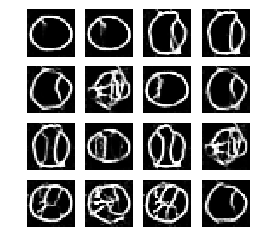

Time for epoch 1602 was 1.2233836650848389

 -> batch -1 done in 82.53221988677979
batch 0 -> batch 9 done in 0.0883326530456543
batch 10 -> batch 19 done in 0.10162734985351562
batch 20 -> batch 29 done in 0.1004178524017334
batch 30 -> batch 39 done in 0.10011720657348633
batch 40

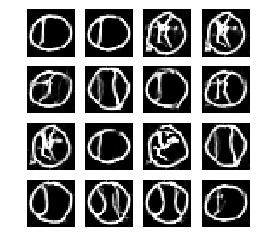

Time for epoch 1702 was 1.2178575992584229

 -> batch -1 done in 82.41197490692139
batch 0 -> batch 9 done in 0.08821415901184082
batch 10 -> batch 19 done in 0.10233116149902344
batch 20 -> batch 29 done in 0.10121560096740723
batch 30 -> batch 39 done in 0.10079717636108398
batch 40

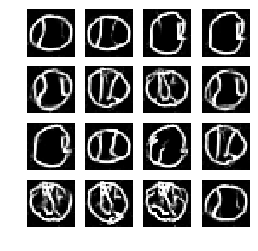

Time for epoch 1802 was 1.217700481414795

 -> batch -1 done in 82.81352996826172
batch 0 -> batch 9 done in 0.08982110023498535
batch 10 -> batch 19 done in 0.10083985328674316
batch 20 -> batch 29 done in 0.10031723976135254
batch 30 -> batch 39 done in 0.10096311569213867
batch 40

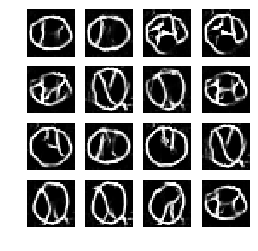

Time for epoch 1902 was 1.2434985637664795

 -> batch -1 done in 83.29967427253723
batch 0 -> batch 9 done in 0.08909344673156738
batch 10 -> batch 19 done in 0.10098099708557129
batch 20 -> batch 29 done in 0.10051727294921875
batch 30 -> batch 39 done in 0.10138130187988281
batch 40

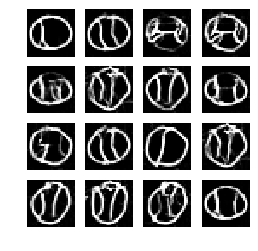

Time for epoch 2002 was 1.1883320808410645

 -> batch -1 done in 82.3484845161438
batch 0 -> batch 9 done in 0.08936500549316406
batch 10 -> batch 19 done in 0.10231232643127441
batch 20 -> batch 29 done in 0.10141992568969727
batch 30 -> batch 39 done in 0.10063004493713379
batch 40

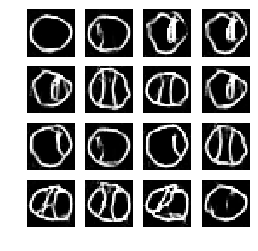

Time for epoch 2102 was 1.19504976272583

 -> batch -1 done in 82.70393490791321
batch 0 -> batch 9 done in 0.08973264694213867
batch 10 -> batch 19 done in 0.10114812850952148
batch 20 -> batch 29 done in 0.10060787200927734
batch 30 -> batch 39 done in 0.10156130790710449
batch 40

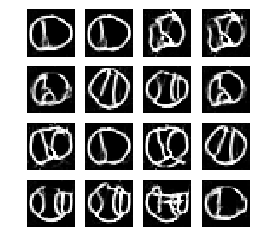

Time for epoch 2202 was 1.2098565101623535

 -> batch -1 done in 82.2932767868042
batch 0 -> batch 9 done in 0.09005928039550781
batch 10 -> batch 19 done in 0.10258603096008301
batch 20 -> batch 29 done in 0.10332679748535156
batch 30 -> batch 39 done in 0.10007429122924805
batch 40

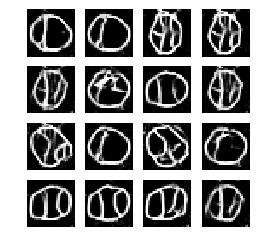

Time for epoch 2302 was 1.232656478881836

 -> batch -1 done in 82.28674697875977
batch 0 -> batch 9 done in 0.08954095840454102
batch 10 -> batch 19 done in 0.10160279273986816
batch 20 -> batch 29 done in 0.10203933715820312
batch 30 -> batch 39 done in 0.10061812400817871
batch 40

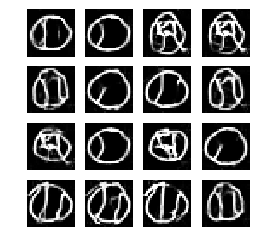

Time for epoch 2402 was 1.197648286819458

 -> batch -1 done in 83.63318729400635
batch 0 -> batch 9 done in 0.089141845703125
batch 10 -> batch 19 done in 0.10199904441833496
batch 20 -> batch 29 done in 0.10047292709350586
batch 30 -> batch 39 done in 0.10059690475463867
batch 40

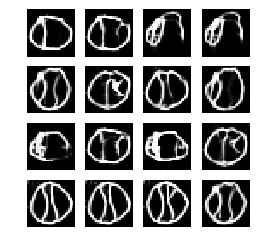

Time for epoch 2502 was 1.2016792297363281

 -> batch -1 done in 82.93275022506714
batch 0 -> batch 9 done in 0.0892648696899414
batch 10 -> batch 19 done in 0.10223269462585449
batch 20 -> batch 29 done in 0.10138154029846191
batch 30 -> batch 39 done in 0.10115647315979004
batch 40

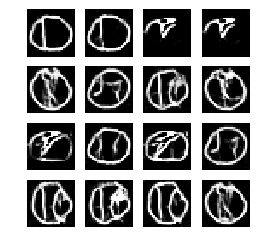

Time for epoch 2602 was 1.2302279472351074

 -> batch -1 done in 82.305899143219
batch 0 -> batch 9 done in 0.0891876220703125
batch 10 -> batch 19 done in 0.10195016860961914
batch 20 -> batch 29 done in 0.10133075714111328
batch 30 -> batch 39 done in 0.10068535804748535
batch 40

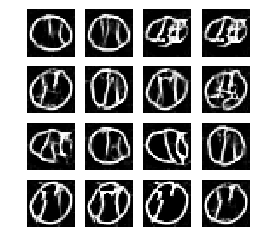

Time for epoch 2702 was 1.212878942489624

 -> batch -1 done in 83.51557850837708
batch 0 -> batch 9 done in 0.08945488929748535
batch 10 -> batch 19 done in 0.10222005844116211
batch 20 -> batch 29 done in 0.10117220878601074
batch 30 -> batch 39 done in 0.10131072998046875
batch 40

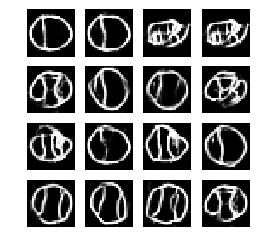

Time for epoch 2802 was 1.2328600883483887

 -> batch -1 done in 82.18425607681274
batch 0 -> batch 9 done in 0.08920955657958984
batch 10 -> batch 19 done in 0.1025240421295166
batch 20 -> batch 29 done in 0.10197305679321289
batch 30 -> batch 39 done in 0.1013329029083252
batch 40

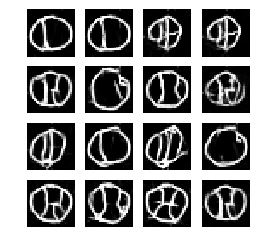

Time for epoch 2902 was 1.288083791732788

CPU times: user 17min 3s, sys: 1min 9s, total: 18min 12s
Wall time: 20min 47s


In [28]:
%%time
train(dataset_train, 1500, epoch_offset=1501)

# Postprocessing

Generate a few random images and view them alongside the discriminator's assessment of them.  Then do the same for some real images. 

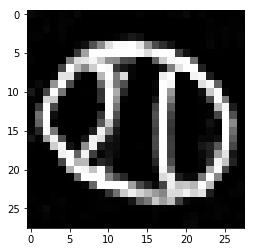

Class prediction (sigmoid of output): 0.01 --> assessed to be a fake image



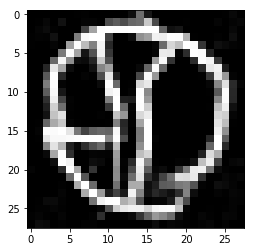

Class prediction (sigmoid of output): 0.01 --> assessed to be a fake image



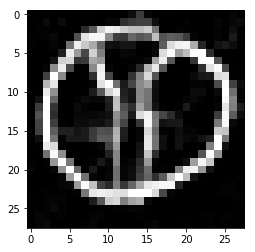

Class prediction (sigmoid of output): 0.01 --> assessed to be a fake image



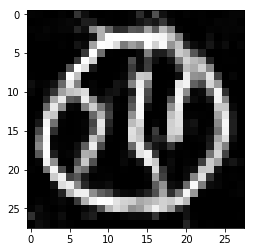

Class prediction (sigmoid of output): 0.35 --> assessed to be a fake image



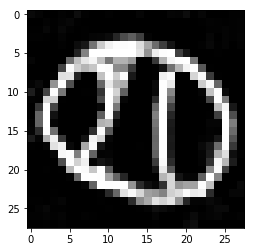

Class prediction (sigmoid of output): 0.02 --> assessed to be a fake image



In [29]:
for _ in range(5):
  noise = tf.random.normal((1, DIM_NOISE))
  generated_image = generator(noise, training=False)
  plt.imshow((generated_image[0, :, :, 0] + 1) * 127.5, cmap='gray')
  plt.show()
  
  pred = tf.math.sigmoid(discriminator(generated_image, training=False))
  print(f'Class prediction (sigmoid of output): {pred[0][0]:.2f}', end='')
  if pred > 0.5:
    print(" --> assessed to be a real image\n")
  else:
    print(" --> assessed to be a fake image\n")


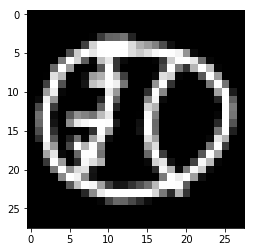

Class prediction (sigmoid of output): 0.90 --> assessed to be a real image



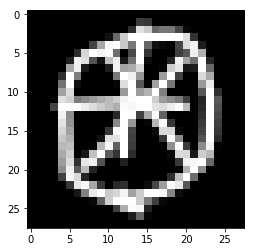

Class prediction (sigmoid of output): 0.97 --> assessed to be a real image



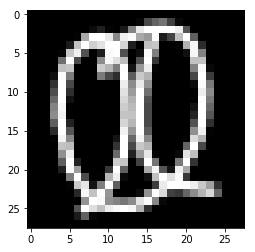

Class prediction (sigmoid of output): 0.90 --> assessed to be a real image



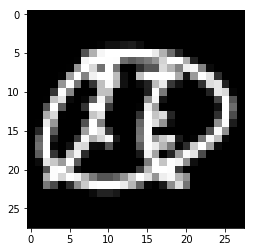

Class prediction (sigmoid of output): 1.00 --> assessed to be a real image



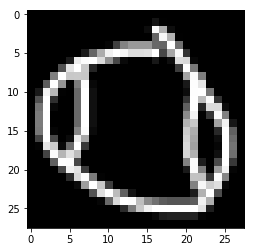

Class prediction (sigmoid of output): 1.00 --> assessed to be a real image



In [30]:
real_images = [d for d in dataset_train]

for i in range(5):
  plt.imshow((real_images[0][i, :, :, 0] + 1) * 127.5, cmap='gray')
  plt.show()

  pred = tf.math.sigmoid(discriminator(real_images[0][i:i+1], training=False))
  print(f'Class prediction (sigmoid of output): {pred[0][0]:.2f}', end='')
  if pred > 0.5:
    print(" --> assessed to be a real image\n")
  else:
    print(" --> assessed to be a fake image\n")

# print(discriminator(generated_image, training=False))

Build a gif of how the output of the generator evolves over time. 

In [0]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    epoch = re.search(r'image.*[^\d](\d+)\.png$', filename)
  
    # Annotation from https://stackoverflow.com/a/43460328/5394584
    image = imageio.imread(filename)
    image = cv2.putText(img=np.copy(image), text=f"epoch={int(epoch.group(1))}", org=(10, image.shape[0]-10),fontFace=2, fontScale=1, color=(255,0,0), thickness=2)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

If running this on Google Colab, use the code below to download the gif image.

In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(anim_file)